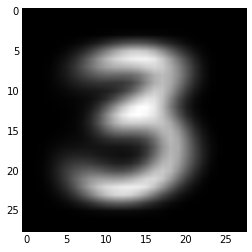

In [147]:
from sklearn.datasets import fetch_mldata
import numpy as np
import os
import gc
from pylab import *

mnist = fetch_mldata('MNIST original')
mnist.data.shape
mnist.target.shape
np.unique(mnist.target)

X, y = mnist.data / 255., mnist.target
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]
X_train.shape
y_train.shape
size=len(y_train)

## extract "3" digits and show their average"
ind = [ k for k in range(size) if y_train[k]==3 ]
extracted_images=X_train[ind,:]

mean_image=extracted_images.mean(axis=0)
imshow(mean_image.reshape(28,28), cmap=cm.gray)
show()

In [2]:
import numpy as np
import math
from copy import deepcopy
from sklearn.cross_validation import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score,recall_score,f1_score
import matplotlib.pyplot as plt
%matplotlib inline
import io

In [3]:
def create_data(data):
    z = data
    for j in z:
        j.insert(0,1)   
    return z

In [4]:
def find_alpha(class_labels):
    alpha1 = {}
    class_count1 = {}
    for i in class_labels:
        if i not in class_count1.keys():
            class_count1[i] = 1
        else:
            class_count1[i] += 1
    classes1 = class_count1.keys()
    for j in  class_count1:
        alpha1[j] = class_count1[j]*1.0/len(class_labels)
    return classes1,class_count1,alpha1

In [5]:
def map_high_dimension(Data,degree):
    polyfeat_object = PolynomialFeatures(degree)
    hd_data = polyfeat_object.fit_transform(Data)
    return hd_data

In [6]:
def segregate_data(data,labels,clabels):
    multi_X = {}
    for i in range(len(clabels)):
        if clabels[i] not in multi_X.keys():
            multi_X[clabels[i]] = []
        for j in range(len(labels)):
            if labels[j][0] == clabels[i]:
                multi_X[clabels[i]].append(data[j]) 
    for i in multi_X:
        multi_X[i] = np.array(multi_X[i])
    return multi_X

In [7]:
def find_sigmoid(theta,data):
    sigmoid = []
    for i in data:
        x = np.dot(theta.transpose(),i)
        sigmoid.append([1.0/(1+np.exp(-x))])
    return np.array(sigmoid)

In [26]:
def gradient_descent(x, y, theta_assume, learning_rate, interation_count):
    theta = np.random.rand(len(x[0]))/10000
    for i in range(interation_count):
        h = find_sigmoid(theta,x)
        new = learning_rate*(np.sum((h-y)*x,axis = 0))
        theta = theta - new
    return theta

In [27]:
def prediction(theta,data):
    sigmoid = find_sigmoid(theta,data)
    predict = []
    for i in sigmoid:
        if i[0] > 0.5:
            predict.append([1])
        elif i[0] < 0.5:
            predict.append([0])
    return np.array(predict)

In [28]:
def mean_squrae_error(pred,y):
    return sum([(i-j)**2 for i,j in zip(pred,y)])/float(len(pred))

In [29]:
def find_confusion_matrix(clabels,actual,predicted):
    cm= []
    for i in clabels:
        tmp =[0]*len(clabels)
        for j in range(len(actual)):
            if actual[j] == i and actual[j] == predicted[j][0]:
                tmp[clabels.index(i)] += 1
            elif actual[j] == i and actual[j] != predicted[j][0]:
                tmp[clabels.index(predicted[j][0])] += 1
        cm.append(tmp)
    return np.array(cm)

In [30]:
def find_accuracy(matrix):
    return np.trace(matrix)*1.0/np.sum(matrix)

In [31]:
def find_precision(matrix):
    pres = []
    x = np.sum(matrix,axis=0)
    for i in range(len(matrix)):
        for j in range(len(matrix)):
            if i == j:
                pres.append(matrix[i][j]*1.0/x[i])
    return pres

In [32]:
def find_recall(matrix):
    rec = []
    x = np.sum(matrix,axis=1)
    for i in range(len(matrix)):
        for j in range(len(matrix)):
            if i == j:
                rec.append(matrix[i][j]*1.0/x[i])
    return rec

In [33]:
def find_fmeasure(prec,rec):
    tmp = []
    for i,j in zip(prec,rec):
        tmp.append(2.0*(i*j)/(i+j))
    return tmp

In [34]:
def roc(clabels,acutal,predicted):
    confmatrix = find_confusion_matrix(clabels,acutal,predicted)
    precision = find_precision(confmatrix)
    recall = find_recall(confmatrix)
    return precision,recall,confmatrix

In [35]:
def cross_validation(data, labels,clabels, n_folds=10,MSE = False):
    cv = KFold(len(labels), n_folds,shuffle= True)
    accuracies = []
    precision_list = []
    confusion = []
    recall_list = []
    training_MSE_list =[]
    testing_MSE_list = []
    i = 0
    for train_ind, test_ind in cv: 
        train_theta = gradient_descent(data[train_ind], labels[train_ind],0.0001,0.0001,300)
        training_MSE = mean_squrae_error(prediction(train_theta,data[train_ind]), labels[train_ind])
        training_MSE_list.append(training_MSE)
        predict = prediction(train_theta,data[test_ind])
        p,r,cm = roc(clabels,labels[test_ind],predict)
        precision_list.append(p)
        recall_list.append(r)
        confusion.append(cm)
        testing_MSE_list.append(mean_squrae_error(predict,labels[test_ind]))
        accuracies.append(accuracy_score(labels[test_ind], predict))
        
    if MSE == True:
        for i in range(len(testing_MSE_list)):
            print 'Fold',i,'Testing Error',testing_MSE_list[i]
        print "Average Mean Square Error"
        print "Training Error \t Testing Error"
        print np.mean(training_MSE_list),"\t",np.mean(testing_MSE_list)
    else:
        for i in range(len(accuracies)):
            print 'Fold',i,'Accuracy',accuracies[i]
        print "Average Accuracy ", np.mean(accuracies)
    return precision_list,recall_list,training_MSE_list,confusion

In [183]:
def softmax(theta,data):
    soft = {}
    for i in data:
        s = 0
        for j in theta:
            s = s + np.exp(np.dot(theta[j].transpose(),i))
        for k in theta:
            prodx = np.exp(np.dot(theta[k].transpose(),i))
            if k not in soft.keys():
                soft[k] = [[(prodx*1.0)/s]]
            else:
                soft[k].append([(prodx*1.0)/s])
    return soft

In [37]:
def indicator(y,cl):
    ind = {}
    for k in cl:
        for l in y:
            if l == k:
                if k not in ind.keys():
                    ind[k] = [[1]]
                else:
                    ind[k].append([1])
            else:
                if k not in ind.keys():
                    ind[k] = [[0]]
                else:
                    ind[k].append([0])
    return ind

In [198]:
def pr(d,data):
    data1 = []
    for i in range(len(data)):
        data1.append(d[i] * data[i])
    return data1

In [192]:
def gradient_descent_soft(x, y, theta_assume, learning_rate, interation_count,classes):
    thetas = {}
    theta = np.random.rand(len(classes),len(x[0]))/10000000
    for i in classes:
        thetas[i] = theta[int(i)]
    indicators = indicator(y,classes)
    for i in range(interation_count):
        h = softmax(thetas,x)
        for i in h:
            d = np.array(h[i])-np.array(indicators[i])
            d1 = pr(d,x)
            sum1 = np.sum(d1,axis =0)                            
            new = learning_rate*sum1
            thetas[i] = thetas[i] - new
    return thetas

In [171]:
def predict_kclass(theta,data,cl):
    pred = []
    predi = []
    for i in data:
        tmp = []
        for j in theta:
            tmp.append((j,np.dot(theta[j].transpose(),i)))
        pred.append(tmp)
    for i in pred:
        predi.append([max(i,key=lambda item:item[1])[0]])
    return predi

In [49]:
def cross_validation_kclass(data, labels,clabels, n_folds=10):
    cv = KFold(len(labels), n_folds,shuffle= True)
    precision_list = []
    confusion = []
    recall_list = []
    training_MSE_list =[]
    testing_MSE_list = []
    i = 0
    for train_ind, test_ind in cv: 
        train_theta = gradient_descent_soft(data[train_ind], labels[train_ind],0.0000001,0.0001,300,clabels)
        training_MSE = mean_squrae_error(predict_kclass(train_theta,data[train_ind],clabels), labels[train_ind])
        training_MSE_list.append(training_MSE)
        predict = predict_kclass(train_theta,data[test_ind],clabels)
        p,r,cm = roc(clabels,labels[test_ind],predict)
        precision_list.append(p)
        recall_list.append(r)
        confusion.append(cm)
        testing_MSE_list.append(mean_squrae_error(predict,labels[test_ind]))
    for i in range(len(testing_MSE_list)):
        print 'Fold',i,'Testing Error',testing_MSE_list[i]
    print "Average Mean Square Error"
    print "Training Error \t Testing Error"
    print np.mean(training_MSE_list),"\t",np.mean(testing_MSE_list)
    return precision_list,recall_list,training_MSE_list,confusion

In [50]:
def evaluation(clabels,acutal,predicted):
    confmatrix = find_confusion_matrix(clabels,acutal,predicted)
    print "Confusion Matrix"
    print confmatrix
    accuracy = find_accuracy(confmatrix)
    print "Accuracy", accuracy
    precision = find_precision(confmatrix)
    print "Precision", precision
    recall = find_recall(confmatrix)
    print "Recall", recall
    f_score =find_fmeasure(precision,recall)
    print "F_score", f_score

In [51]:
"""Z= deepcopy(X_train)
Z = create_data(Z)"""
#Z = np.array(Z)

classes,class_count,alpha = find_alpha(y_train)

In [52]:
soft_theta = gradient_descent_soft(X_train,y_train,0.0001,0.0001,300,classes)

In [53]:
xx = predict_kclass(soft_theta,X_test,classes)

In [54]:
evaluation(classes,y_test,xx)

Confusion Matrix
[[ 980    0    0    0    0    0    0    0    0    0]
 [1135    0    0    0    0    0    0    0    0    0]
 [1032    0    0    0    0    0    0    0    0    0]
 [1010    0    0    0    0    0    0    0    0    0]
 [ 982    0    0    0    0    0    0    0    0    0]
 [ 892    0    0    0    0    0    0    0    0    0]
 [ 958    0    0    0    0    0    0    0    0    0]
 [1028    0    0    0    0    0    0    0    0    0]
 [ 974    0    0    0    0    0    0    0    0    0]
 [1009    0    0    0    0    0    0    0    0    0]]
Accuracy 0.098
Precision [0.098000000000000004, nan, nan, nan, nan, nan, nan, nan, nan, nan]
Recall [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
F_score [0.1785063752276867, nan, nan, nan, nan, nan, nan, nan, nan, nan]


c:\python27\lib\site-packages\ipykernel\__main__.py:7: RuntimeWarning: invalid value encountered in double_scalars


In [64]:
classes

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]

In [55]:
X_train.shape

(60000, 784)

In [59]:
X_train[0:100][:].shape

(100, 784)

In [63]:
cld = {}
for i in range(len(y_train)):
    if y[i] not in cld.keys():
        cld[y[i]] = [i]
    else:
        cld[y[i]].append(i)

In [65]:
cld1= {}
for i in cld:
    cld1[i] = (min(cld[i]),max(cld[i]))

In [199]:
X_new = []
y_new = []
for i in cld1:
    x=cld1[i][0]+1000
    y = cld1[i][0]+1100
    for l in range(x,y):
        X_new.append(X_train[l])
        y_new.append(y_train[l])
X_new = np.array(X_new)
y_new = np.array(y_new)

In [200]:
soft_theta1 = gradient_descent_soft(X_new,y_new,0.0001,0.0001,300,classes)

In [202]:
xx1 = predict_kclass(soft_theta1,X_test,classes)

In [203]:
evaluation(classes,y_test,xx1)

Confusion Matrix
[[ 942    0    2    2    0    6   18    1    9    0]
 [   0 1063   14    3    1    6    4    0   44    0]
 [  30   21  823   26   17    2   41   24   41    7]
 [   7    1   31  856    1   35   10   14   33   22]
 [   6    9    4    0  858    1   18    2   11   73]
 [  26    2    1   89   20  648   36   11   46   13]
 [  16    3   12    1   20   12  888    1    5    0]
 [   6   31   48    1   14    0    0  887    7   34]
 [  11   19    8   37   17   26   17   18  800   21]
 [  22   12   12   10   55   12    3   36   11  836]]
Accuracy 0.8601
Precision [0.8836772983114447, 0.91559000861326445, 0.86178010471204192, 0.83512195121951216, 0.85543369890329013, 0.86631016042780751, 0.85797101449275359, 0.89235412474849096, 0.79443892750744782, 0.83101391650099399]
Recall [0.96122448979591835, 0.93656387665198237, 0.79748062015503873, 0.8475247524752475, 0.87372708757637474, 0.726457399103139, 0.92693110647181631, 0.86284046692607008, 0.82135523613963035, 0.82854311199207131]
F